# HW4P2: Attention-based Speech Recognition

HW Writeup: [TODO] <br>
Kaggle Competition Link: https://www.kaggle.com/competitions/attention-based-speech-recognition <br>
Kaggle Dataset Link: https://www.kaggle.com/competitions/attention-based-speech-recognition/data
<br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

In [70]:
import torch
import torchaudio
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchaudio.transforms as tat

# import torchsummary

import numpy as np
import os
import random

import gc
import time

import pandas as pd
from tqdm.notebook import tqdm as blue_tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn
import json

import math
from typing import Optional, List


#imports for decoding and distance calculation
try:
    import wandb
    import torchsummaryX
    import Levenshtein
except:
    print("Didnt install some/all imports")
from torchsummaryX import summary
import warnings
warnings.filterwarnings('ignore')

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda:0


# Kaggle Dataset Download

In [71]:
# # to download the dataset
# !kaggle competitions download -c attention-based-speech-recognition

# # to unzip data quickly and quietly
# !unzip -q attention-based-speech-recognition.zip -d ./data

# Character-based LibriSpeech (HW4P2)

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required??

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them?
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2?
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


# Config

In [72]:
config = dict (
    train_dataset       = 'train-clean-360', # train-clean-100, train-clean-360, train-clean-460
    batch_size          = 128,
    epochs              = 100,
    lr                  = 1e-3,
    weight_decay        = 5e-5
)

In [73]:
VOCAB = [
    '<pad>', '<sos>', '<eos>',
    'A',   'B',    'C',    'D',
    'E',   'F',    'G',    'H',
    'I',   'J',    'K',    'L',
    'M',   'N',    'O',    'P',
    'Q',   'R',    'S',    'T',
    'U',   'V',    'W',    'X',
    'Y',   'Z',    "'",    ' ',
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

def transcript_to_ind(transcript):
    map_func = np.vectorize(VOCAB_MAP.get)
    index_array = map_func(transcript)
    return index_array


In [74]:
def cepstral_mean_normalization(features):
    mean = np.mean(features, axis=0)
    normalized_features = features - mean
    return normalized_features

class SpeechDatasetME(torch.utils.data.Dataset): # Memory efficient
    # Loades the data in get item to save RAM
    def __init__(self, root, partition= "train-clean-360", transforms = None, cepstral=True):
        self.VOCAB      = VOCAB
        self.cepstral   = cepstral

        if partition == "train-clean-100" or partition == "train-clean-360" or partition == "dev-clean":
            mfcc_dir       = f"/home/yuwu3/4P2/data/11-785-f23-hw4p2/{partition}/mfcc"#  path to the mfccs
            transcript_dir = f"/home/yuwu3/4P2/data/11-785-f23-hw4p2/{partition}/transcripts" # path to the transcripts
            mfcc_files          =  sorted(os.listdir(mfcc_dir))# create a list of paths for all the mfccs in the mfcc directory
            transcript_files    =  sorted(os.listdir(transcript_dir))# create a list of paths for all the transcripts in the transcript directory

        else:
            mfcc_dir       = f"/home/yuwu3/4P2/data/11-785-f23-hw4p2/train-clean-100/mfcc"# path to the mfccs in the train clean 100 partition
            transcript_dir = f"/home/yuwu3/4P2/data/11-785-f23-hw4p2/train-clean-100/transcripts"# path to the transcripts in the train clean 100 partition
            mfcc_files          = sorted(os.listdir(mfcc_dir))# create a list of paths for all the mfccs in the mfcc directory
            transcript_files    = sorted(os.listdir(transcript_dir))# create a list of paths for all the transcripts in the transcript directory

            mfcc_dir       = f"/home/yuwu3/4P2/data/11-785-f23-hw4p2/train-clean-360/mfcc"# path to the mfccs in the train clean 100 partition
            transcript_dir = f"/home/yuwu3/4P2/data/11-785-f23-hw4p2/train-clean-360/transcripts"# path to the transcripts in the train clean 100 partition
            mfcc_files += sorted(os.listdir(mfcc_dir))
            transcript_files += sorted(os.listdir(transcript_dir))

        assert len(mfcc_files) == len(transcript_files)
        length = len(mfcc_files)# TODO

        self.mfcc_dir = mfcc_dir
        self.transcript_dir = transcript_dir
        self.mfcc_files         = mfcc_files
        self.transcript_files   = transcript_files
        self.length             = len(transcript_files)
        print("Loaded file paths ME: ", partition)


    def __len__(self):
        return self.length

    def __getitem__(self, ind):

        # Load the mfcc and transcripts from the mfcc and transcript paths created earlier
        mfcc        =  np.load(os.path.join(self.mfcc_dir, self.mfcc_files[ind]))
        transcript  = np.load(os.path.join(self.transcript_dir, self.transcript_files[ind]))
         # NOT Remove [SOS] and [EOS] from the transcript

        # Normalize the mfccs and map the transcripts to integers
        mfcc                = cepstral_mean_normalization(mfcc)
        transcript_mapped   = transcript_to_ind(transcript)

        return torch.FloatTensor(mfcc), torch.LongTensor(transcript_mapped)

    def collate_fn(self,batch):
        # batch of input mfcc coefficients
        batch_mfcc, batch_transcript = zip(*batch) # TODO
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc = torch.tensor([len(seq) for seq in batch_mfcc])
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True) # TODO
        lengths_transcript = torch.tensor([len(seq) for seq in batch_transcript])
        return batch_mfcc_pad, batch_transcript_pad, lengths_mfcc, lengths_transcript



In [75]:
class SpeechDatasetTest(torch.utils.data.Dataset):

    def __init__(self, root, partition, cepstral=False):

        self.mfcc_dir   = f"/home/yuwu3/4P2/data/11-785-f23-hw4p2/test-clean/mfcc"# path to the test-clean mfccs
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.mfccs = []
        for i, filename in enumerate(self.mfcc_files):
            mfcc = np.load(os.path.join(self.mfcc_dir, self.mfcc_files[i])) # load the mfccs
            if cepstral:
                # Normalize the mfccs
                mfcc = cepstral_mean_normalization(mfcc)# TODO
            # append the mfcc to the mfcc list created earlier
            self.mfccs.append(mfcc)
        self.length = len(self.mfccs)
        print("Loaded: ", partition)

    def __len__(self):
        return self.length # TODO

    def __getitem__(self, ind):
        mfcc = torch.FloatTensor(self.mfccs[ind])
        return mfcc

    # def collate_fn(self,batch):
    #     batch_x, lengths_x = [], []
    #     for x in batch:
    #         # Append the mfccs and their lengths to the lists created above
    #     # pack the mfccs using the pad_sequence function from pytorch
    #     batch_x_pad = # TODO
    #     return batch_x_pad, torch.tensor(lengths_x)
    
    def collate_fn(self,batch):
        batch_mfcc = batch # TODO
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc = torch.tensor([len(seq) for seq in batch_mfcc])        
        return batch_mfcc_pad, lengths_mfcc

In [76]:
DATA_DIR        = 'data/11-785-f23-hw4p2'
PARTITION       = 'train-clean-100'
CEPSTRAL        = True

train_dataset   = SpeechDatasetME( # Or AudioDatasetME
    root        = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL
)
valid_dataset   = SpeechDatasetME(
    root        = DATA_DIR,
    partition   = 'dev-clean',
    cepstral    = CEPSTRAL
)
test_dataset    = SpeechDatasetTest(
    root        = DATA_DIR,
    partition   = 'test-clean',
    cepstral    = CEPSTRAL,
)

gc.collect()

Loaded file paths ME:  train-clean-100
Loaded file paths ME:  dev-clean
Loaded:  test-clean


484

In [77]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

valid_loader    = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = valid_dataset.collate_fn
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn
)

print("No. of train mfccs   : ", train_dataset.__len__())
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Valid batches        : ", valid_loader.__len__())
print("Test batches         : ", test_loader.__len__())

No. of train mfccs   :  28539
Batch size           :  128
Train batches        :  223
Valid batches        :  22
Test batches         :  21


In [79]:
def verify_dataset(dataset, partition= 'train-clean-100'):
    print("\nPartition loaded     : ", partition)
    if partition != 'test-clean':
        print("Max mfcc length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg mfcc length          : ", np.mean([data[0].shape[0] for data in dataset]))
        print("Max transcript length    : ", np.max([data[1].shape[0] for data in dataset]))
        print("Max transcript length    : ", np.mean([data[1].shape[0] for data in dataset]))
    else:
        print("Max mfcc length          : ", np.max([data.shape[0] for data in dataset]))
        print("Avg mfcc length          : ", np.mean([data.shape[0] for data in dataset]))

# verify_dataset(train_dataset, partition= 'train-clean-100')
# verify_dataset(valid_dataset, partition= 'dev-clean')
# verify_dataset(test_dataset, partition= 'test-clean')
# dataset_max_len  = max(
#     np.max([data[0].shape[0] for data in train_dataset]),
#     np.max([data[0].shape[0] for data in valid_dataset]),
#     np.max([data.shape[0] for data in test_dataset])
# )
# print("\nMax Length: ", dataset_max_len)

Check if you are loading the data correctly with the following:

- Train Dataset
```
Partition loaded:  train-clean-100
Max mfcc length:  2448
Average mfcc length:  1264.6258453344547
Max transcript:  400
Average transcript length:  186.65321139493324
```

- Dev Dataset
```
Partition loaded:  dev-clean
Max mfcc length:  3260
Average mfcc length:  713.3570107288198
Max transcript:  518
Average transcript length:  108.71698113207547
```

- Test Dataset
```
Partition loaded:  test-clean
Max mfcc length:  3491
Average mfcc length:  738.2206106870229
```

If your values is not matching, read hints, think what could have gone wrong. Then approach TAs.

## Utils


In [80]:
class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

def plot_attention(attention):
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    seaborn.heatmap(attention, cmap='GnBu')
    plt.show()

def save_model(model, optimizer, scheduler, tf_scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'tf_scheduler'             : tf_scheduler,
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(best_path, epoch_path, model, mode= 'best', metric= 'valid_acc', optimizer= None, scheduler= None, tf_scheduler= None):
    if mode == 'best':
        checkpoint  = torch.load(best_path)
        print("Loading best checkpoint: ", checkpoint[metric])
    else:
        checkpoint  = torch.load(epoch_path)
        print("Loading epoch checkpoint: ", checkpoint[metric])

    model.load_state_dict(checkpoint['model_state_dict'], strict= False)

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #optimizer.param_groups[0]['lr'] = 1.5e-3
        optimizer.param_groups[0]['weight_decay'] = 1e-5
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if tf_scheduler != None:
        tf_scheduler    = checkpoint['tf_scheduler']

    epoch   = checkpoint['epoch']
    metric  = torch.load(best_path)[metric]

    return [model, optimizer, scheduler, tf_scheduler, epoch, metric]

class TimeElapsed():
    def __init__(self):
        self.start  = -1

    def time_elapsed(self):
        if self.start == -1:
            self.start = time.time()
        else:
            end = time.time() - self.start
            hrs, rem    = divmod(end, 3600)
            min, sec    = divmod(rem, 60)
            min         = min + 60*hrs
            print("Time Elapsed: {:0>2}:{:02}".format(int(min),int(sec)))
            self.start  = -1

## Modules

# Transformer Encoder

In [81]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, projection_size, max_seq_len= 550):
        super().__init__()
        # Read the Attention Is All You Need paper to learn how to code code the positional encoding
        encoding = torch.zeros(max_seq_len, projection_size).to(DEVICE)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, projection_size, 2).float() * -(np.log(10000.0) / projection_size))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = encoding.unsqueeze(0)
        self.register_buffer('encoding', encoding)

    def forward(self, x):
        batch_encoding = self.encoding.repeat(x.shape[0], 1,1)
        # print(x.shape, batch_encoding.shape)
        return torch.cat([x, batch_encoding[:,:x.shape[1],:]], dim=2)

In [82]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        x = self.dropout(x)
        return x

class LockedDropout(torch.nn.Module):
    def __init__(self, p=0.5):
        self.p = p
        super().__init__()
        
    def forward(self, x, timestep):
        if not self.training or not self.p:
            return x
        if timestep == 0:
            x = x.clone()
            mask = x.new_empty(x.shape, requires_grad=False).bernoulli_(1 - self.p)
            mask = mask.div_(1 - self.p)
            self.mask = mask
        return x * self.mask

class EmbeddingDropout(torch.nn.Module):
    def __init__(self, p=0.5):
        self.p = p
        super().__init__()
        
    def forward(self, embed, words):
        if self.training:
            mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - self.p).expand_as(embed.weight) / (1 - self.p)
            masked_embed_weight = mask * embed.weight
        else:
            masked_embed_weight = embed.weight
        X = torch.nn.functional.embedding(words, masked_embed_weight)
        return X

class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, downsample=False, dropout=0.0):
        super(pBLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True, dropout = dropout) # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
        self.downsample = downsample

    def forward(self, x_packed): # x_packed is a PackedSequence
        x, lengths = pad_packed_sequence(x_packed, batch_first=True)
        if self.downsample:
            x, lengths = self.trunc_reshape(x, lengths)
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        x, _ = self.blstm(x)
        return x

    def trunc_reshape(self, x, x_lens):
        if x.shape[1] % 2 != 0:
            x = x[:, :-1, :]
            x_lens -= 1
        B, L, C = x.shape
        x = x.reshape(B, L // 2, C * 2)
        x_lens = x_lens // 2
        return x, x_lens

class TransformerEncoder(torch.nn.Module):
    def __init__(self, projection_size, num_heads, dropout= 0.1):
        super().__init__()
        self.projection_size = projection_size
        # create the key, query and value weights
        self.KW         = nn.Linear(projection_size, projection_size) # TODO
        self.VW         = nn.Linear(projection_size, projection_size) # TODO
        self.QW         = nn.Linear(projection_size, projection_size) # TODO
        self.permute    = PermuteBlock()
        # Compute multihead attention. You are free to use the version provided by pytorch
        self.attention  = nn.MultiheadAttention(embed_dim=projection_size, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.bn1        = nn.LayerNorm(projection_size, eps=1e-6)  
        self.bn2        = nn.LayerNorm(projection_size, eps=1e-6) 
        # Feed forward neural network
        self.MLP        = nn.Sequential(
            nn.Linear(projection_size, 2 * projection_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2 * projection_size, projection_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # compute the key, query and value
        key     = self.KW(x)# TODO
        value   = self.VW(x) # TODO
        query   = self.QW(x) # TODO

        # compute the output of the attention module
        out1, _  =  self.attention(query, key, value) # TODO
        if torch.any(torch.isnan(out1)):
            print("self attention out1 is nan! output: ", out1)
            assert(False)
        # Create a residual connection between the input and the output of the attention module
        out1    = out1 + x # TODO
        # Apply batch norm to out1
        out1    = self.bn1(out1) # TODO
        if torch.any(torch.isnan(out1)):
            print("layernorm out1 is nan! output: ", out1)
            assert(False)
        # Apply the output of the feed forward network
        out2    = self.MLP(out1) # TODO
        # Apply a residual connection between the input and output of the  FFN
        out2    = out2 + out1 # TODO
        # Apply batch norm to the output
        out2    = self.bn2(out2) # TODO
        if torch.any(torch.isnan(out2)):
            print("layernorm out2 is nan! output: ", out2)
            assert(False)
        return out2


In [83]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        assert self.head_dim * num_heads == d_model, "Invalid number of heads or d_model dimensions"
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.wo = nn.Linear(d_model, d_model)
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        q = self.wq(q).view(batch_size, -1, self.num_heads, self.head_dim)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.head_dim)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.head_dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.wo(out)
        return out
    
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return out
    
class AddNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(AddNorm, self).__init__()
        self.norm = nn.LayerNorm(d_model, eps=eps)
    def forward(self, x, residual):
        out = x + residual
        out = self.norm(out)
        return out
    
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = AddNorm(d_model)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = AddNorm(d_model)
    def forward(self, x, mask=None):
        x1 = self.self_attn(x, x, x, mask)
        x = self.norm1(x, x1)
        x1 = self.ffn(x)
        x = self.norm2(x, x1)
        return x

In [84]:
class TransformerListener(torch.nn.Module):
    def __init__(self,
                 input_size,
                 base_lstm_layers        = 2,
                 pblstm_layers           = 2,
                 listener_hidden_size    = 256,
                 position_size           = 32,
                 n_heads                 = 8,
                 tf_blocks               = 4,
                 conv_dropout            = 0.0,
                 attn_dropout            = 0.1):
        super().__init__()
        # create an lstm layer
        self.lstm_layers      = nn.Sequential(
            pBLSTM(listener_hidden_size * 2, listener_hidden_size, downsample=True, dropout=0.1),
            pBLSTM(listener_hidden_size * 2, listener_hidden_size, downsample=False, dropout=0.1),
            pBLSTM(listener_hidden_size * 2, listener_hidden_size // 2, downsample=False, dropout=0.1),
        )
        self.permute = PermuteBlock()
        self.embedding2      = nn.Sequential(
            self.permute,
            nn.Conv1d(input_size, input_size*8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(input_size*8),
            nn.GELU(),
            # torch.nn.Dropout(conv_dropout),
            nn.Conv1d(input_size*8, input_size*16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(input_size*16),
            nn.GELU(),
            # torch.nn.Dropout(conv_dropout),
            nn.Conv1d(input_size*16, listener_hidden_size, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(listener_hidden_size),
            nn.GELU(),
            # torch.nn.Dropout(conv_dropout),
            self.permute
        )

        # compute the postion encoding
        self.positional_encoding    = PositionalEncoding(listener_hidden_size, max_seq_len=550, dropout=0.1) # TODO

        # create a sequence of transformer blocks
        # self.transformer_encoder    = torch.nn.Sequential(
        #     TransformerEncoder(listener_hidden_size, num_heads=n_heads, dropout=attn_dropout),
        #     TransformerEncoder(listener_hidden_size, num_heads=n_heads, dropout=attn_dropout),
        #     TransformerEncoder(listener_hidden_size, num_heads=n_heads, dropout=attn_dropout),
        #     TransformerEncoder(listener_hidden_size, num_heads=n_heads, dropout=attn_dropout)
        # )
        self.transformer_encoder    = torch.nn.Sequential(
            EncoderBlock(listener_hidden_size, n_heads, listener_hidden_size*2, attn_dropout),
            EncoderBlock(listener_hidden_size, n_heads, listener_hidden_size*2, attn_dropout),
            EncoderBlock(listener_hidden_size, n_heads, listener_hidden_size*2, attn_dropout),
            EncoderBlock(listener_hidden_size, n_heads, listener_hidden_size*2, attn_dropout),
        )
        # for i in range(tf_blocks):
        #     # TODO

    def forward(self, x, x_len):
        # Pass the output through the embedding
        x                  = self.embedding2(x)
        x_len = (x_len - 1) // 4 + 1
        # pack the inputs before passing them to the LSTm
        x_packed                = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
        # Pass the packed sequence through the lstm
        lstm_out                = self.lstm_layers(x_packed)
        # lstm_out = x_packed
        # Unpack the output of the lstm
        output, output_lengths  = pad_packed_sequence(lstm_out, batch_first=True)
        
        
        
        # calculate the new output length
        # output_lengths          = (output_lengths - 1) // 4 + 1# TODO
        # calculate the position encoding and concat it to the output
        output  = self.positional_encoding(output) # TODO
        if torch.any(torch.isnan(output)):
            print("listener postional out is nan! output: ", output)
            assert(False)
        # Pass the output of the positional encoding through the transformer encoder
        output  = self.transformer_encoder(output) # TODO
        return output, output_lengths

In [85]:
class lockeddropout(nn.Module):
    def __init__(self, p=0.5):
        self.p = p
        super().__init__()
    def forward(self, x):
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(x.shape[0], 1, x.shape[2], requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask
    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'
    
class Listener(torch.nn.Module):
  def __init__(self, input_size, encoder_hidden_size):
    super(Listener, self).__init__()
    # self.dropout = 0
    self.input_size = input_size
    self.encoder_hidden_size = encoder_hidden_size
    # print("?????????????????????????????????????????????")

    #TODO: You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
    self.embedding1 = nn.Sequential(
        nn.Conv1d(input_size, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
    )
    self.embedding2 = nn.Sequential(
        nn.Conv1d(128 + input_size, 128, kernel_size = 5, stride = 1, padding = 2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
    )
    self.embedding3 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size = 7, stride = 1, padding = 3),
        nn.BatchNorm1d(128),
        nn.ReLU(),
    )
    self.embedding4 = nn.Sequential(
        nn.Conv1d(128 + 128, encoder_hidden_size // 4, kernel_size = 7, stride = 1, padding = 3),
        nn.BatchNorm1d(encoder_hidden_size // 4),
        nn.ReLU(),
    )
    self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
        pBLSTM(encoder_hidden_size // 4, 240, downsample = False),
        pBLSTM(480, 240, downsample = False),
        pBLSTM(960, 240, downsample = True),
        pBLSTM(960, encoder_hidden_size // 2, downsample = True)
    )
  def forward(self, x, x_lens):
    # self.dropout = Drop(self.training, config['epochs'])
    x = x.permute(0, 2, 1)
    x_embed = self.embedding1(x)
    # x_embed = nn.Dropout(self.dropout)(x_embed)
    x_embed2 = self.embedding2(torch.cat((x_embed, x), dim = 1))
    # x_embed2 = nn.Dropout(self.dropout)(x_embed2)
    x_embed3 = self.embedding3(x_embed2)
    # x_embed3 = nn.Dropout(self.dropout)(x_embed3)
    x_embed4 = self.embedding4(torch.cat((x_embed3, x_embed2), dim = 1))
    # x_embed4 = nn.Dropout(self.dropout)(x_embed4)
    x_embed4 = x_embed4.permute(0, 2, 1)
    x_pack = pack_padded_sequence(x_embed4, x_lens, batch_first = True, enforce_sorted = False)
    final = self.pBLSTMs(x_pack)
    encoder_outputs, encoder_lens = pad_packed_sequence(final, batch_first = True)
    return encoder_outputs, encoder_lens

In [86]:
class Attention(torch.nn.Module):
  def __init__(self, listener_hidden_size, speller_hidden_size, projection_size):
    super().__init__()
    self.KW = nn.Linear(listener_hidden_size, projection_size)
    self.VW = nn.Linear(listener_hidden_size, projection_size)
    self.QW = nn.Linear(speller_hidden_size, projection_size)
    self.permute    = PermuteBlock()

  def set_key_value(self, encoder_outputs):
    self.key = self.KW(encoder_outputs)
    self.value = self.VW(encoder_outputs)

  def compute_context(self, decoder_context):
    # compute the key, query and value
    query   = self.QW(decoder_context) # TODO
    # print(self.key.shape, query.shape)
    raw_weights = torch.bmm(torch.unsqueeze(query, 1), self.permute(self.key)).squeeze(1)
    attention_weights = torch.nn.functional.softmax(raw_weights, dim=1) # normalize this
    attention_context = torch.bmm(attention_weights.unsqueeze(1), self.value).squeeze(1)
    return attention_context, attention_weights
  
# class Attention(torch.nn.Module):
#   def __init__(self, listener_hidden_size, speller_hidden_size, projection_size):
#     super().__init__()
#     self.VW = nn.Linear(listener_hidden_size, projection_size)
#     self.KW = nn.Linear(listener_hidden_size, projection_size)
#     self.QW = nn.Linear(speller_hidden_size, projection_size)
#     self.batch_size = config['batch_size']

#   def set_key_value(self, encoder_outputs):
#     self.key = self.KW(encoder_outputs)
#     self.value = self.VW(encoder_outputs)

#   def compute_context(self, decoder_context):
#     query = self.QW(decoder_context) # B*P
#     raw_weights = torch.bmm(torch.unsqueeze(query, 1), self.key.transpose(1, 2)).squeeze(1)
#     attention_weights = torch.nn.functional.softmax(raw_weights, dim=1)
#     context = torch.bmm(attention_weights.unsqueeze(1), self.value).squeeze(1)
#     return context, attention_weights

In [87]:
class Speller(torch.nn.Module):

  # Refer to your HW4P1 implementation for help with setting up the language model.
  # The only thing you need to implement on top of your HW4P1 model is the attention module and teacher forcing.

  def __init__(self, attender:Attention, embedding_size, speller_hidden_size, projection_size, max_timesteps):
    super(). __init__()
    self.attend = attender # Attention object in speller
    self.max_timesteps = max_timesteps# Max timesteps
    self.embedding_size = embedding_size
    self.speller_hidden_size = speller_hidden_size
    self.projection_size = projection_size

    self.embedding_layer =  torch.nn.Embedding(len(VOCAB), embedding_size)# Embedding layer to convert token to latent space
    self.embedding = EmbeddingDropout(0.1)

    self.lstm_cells =  torch.nn.Sequential(
        nn.LSTMCell(embedding_size + projection_size, speller_hidden_size),
        nn.LSTMCell(speller_hidden_size, speller_hidden_size),
        nn.LSTMCell(speller_hidden_size, speller_hidden_size)
    )# Create a sequence of LSTM Cells
    self.lock_drops = torch.nn.Sequential(
            LockedDropout(0.2),
            LockedDropout(0.2),
            LockedDropout(0.2),
    )
    
    # For CDN (Feel free to change)
    self.output_to_char = nn.Linear(projection_size + speller_hidden_size, embedding_size)# Linear module to convert outputs to correct hidden size (Optional: TO make dimensions match)
    self.activation = nn.Tanh() # Check which activation is suggested
    self.char_prob = nn.Linear(embedding_size, len(VOCAB)) # Linear layer to convert hidden space back to logits for token classification
    self.char_prob.weight = self.embedding_layer.weight # Weight tying

  def lstm_step(self, input_word, hidden_state, t):
    for i in range(len(self.lstm_cells)):
      if i==0:
        hidden_state[i] = self.lstm_cells[i](input_word, hidden_state[i])
        hidden_state[i] = (self.lock_drops[i](hidden_state[i][0], t), hidden_state[i][1])
      else:
        hidden_state[i] = self.lstm_cells[i](hidden_state[i-1][0], hidden_state[i])
        hidden_state[i] = (self.lock_drops[i](hidden_state[i][0], t), hidden_state[i][1])  
    return hidden_state[-1][0], hidden_state # What information does forward() need?

  def CDN(self, input):
    out = self.output_to_char(input)
    out = self.activation(out)
    out = self.char_prob(out)
    return out
  
  def forward (self, y=None, teacher_forcing_ratio=1, batch_size=1):
    attn_context = torch.zeros(batch_size, self.projection_size).to(DEVICE) # initial context tensor for time t = 0
    output_symbol = torch.ones((batch_size, SOS_TOKEN), dtype=torch.int64).to(DEVICE) # Set it to SOS for time t = 0
    raw_outputs = []
    attention_plot = []

    if y is None:
      timesteps = self.max_timesteps
      teacher_forcing_ratio = 0 #Why does it become zero?
    else:
      timesteps = y.shape[1] # How many timesteps are we predicting for?

    hidden_states_list = [None] * len(self.lstm_cells) # Initialize your hidden_states list here similar to HW4P1
    for t in range(timesteps):
      p = random.random() # generate a probability p between 0 and 1
      if y is not None and t>0:
        if p < teacher_forcing_ratio: # Why do we consider cases only when t > 0? What is considered when t == 0? Think.
          output_symbol = y[:, t-1] # Take from y, else draw from probability distribution
        # else:
        #   output_symbol = nn.functional.gumbel_softmax(raw_outputs[t - 1])  #try argmax

      char_embed = self.embedding(self.embedding_layer, output_symbol).squeeze() # Embed the character symbol
      # Concatenate the character embedding and context from attention, as shown in the diagram
      lstm_input = torch.cat((char_embed, attn_context), dim=1)
      lstm_out, hidden_states_list = self.lstm_step(lstm_input, hidden_states_list, t) # Feed the input through LSTM Cells and attention.
      if torch.any(torch.isnan(lstm_out)):
            print(f"speller lstm out is nan! time={t} lstm_out: ", lstm_out)
            assert(False)
      # What should we retrieve from forward_step to prepare for the next timestep?
      attn_context, attn_weights = self.attend.compute_context(lstm_out) # Feed the resulting hidden state into attention
      if torch.any(torch.isnan(attn_context)):
            print(f"attn_context is nan! time={t} attn_context: ", attn_context)
            assert(False)
      cdn_input = torch.cat((lstm_out, attn_context), dim=1) # TODO: You need to concatenate the context from the attention module with the LSTM output hidden state, as shown in the diagram
      raw_pred = self.CDN(cdn_input) # call CDN with cdn_input
      if torch.any(torch.isnan(raw_pred)):
            print(f"CDN is nan! time={t} CDN: ", raw_pred)
            assert(False)
      # Generate a prediction for this timestep and collect it in output_symbols
      output_symbol = torch.argmax(raw_pred, dim=1) # Draw correctly from raw_pred
      raw_outputs.append(raw_pred) # for loss calculation
      attention_plot.append(attn_weights) # for plotting attention plot

    attention_plot = torch.stack(attention_plot, dim=1)
    raw_outputs = torch.stack(raw_outputs, dim=1)
    return raw_outputs, attention_plot

In [89]:
class ASRModel(torch.nn.Module):
  def __init__(self, input_size, listener_hidden_size, speller_hidden_size, projection_size, 
               embedding_size, max_timesteps): # add parameters
    super().__init__()

    # Pass the right parameters here
    # self.listener = TransformerListener(input_size, listener_hidden_size=listener_hidden_size)
    self.listener = Listener(input_size, listener_hidden_size)
    self.attend = Attention(listener_hidden_size, speller_hidden_size, projection_size)
    self.speller = Speller(self.attend, embedding_size, speller_hidden_size, projection_size, max_timesteps)

    self.augmentations  = torch.nn.Sequential(
            PermuteBlock(),
            tat.TimeMasking(0.2),
            tat.FrequencyMasking(0.2),
            PermuteBlock()
        )
  def forward(self, x,lx,y=None,teacher_forcing_ratio=1):
    if self.training:
      x = self.augmentations(x)
      
    # Encode speech features
    encoder_outputs, _ = self.listener(x,lx)

    # We want to compute keys and values ahead of the decoding step, as they are constant for all timesteps
    # Set keys and values using the encoder outputs
    self.attend.set_key_value(encoder_outputs)

    # Decode text with the speller using context from the attention
    raw_outputs, attention_plots = self.speller(y=y,teacher_forcing_ratio=teacher_forcing_ratio, batch_size=x.shape[0])

    return raw_outputs, attention_plots

# Model Setup

In [90]:
torch.cuda.empty_cache()
gc.collect()
model = ASRModel(
    input_size=28,
    listener_hidden_size=512,
    speller_hidden_size=512,
    projection_size=256,
    embedding_size=256,
    max_timesteps=550,
)
model = model.to(DEVICE)
print(model)

for data in train_loader:
    x, y, lx, ly = data
    print("x,y, lx, ly:", x.shape, y.shape, lx.shape, ly.shape)
    break
summary(model, x.to(DEVICE), lx, y.to(DEVICE))


ASRModel(
  (listener): Listener(
    (embedding1): Sequential(
      (0): Conv1d(28, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (embedding2): Sequential(
      (0): Conv1d(156, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (embedding3): Sequential(
      (0): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (embedding4): Sequential(
      (0): Conv1d(256, 128, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(128, 240, batch_first=T

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_augmentations.PermuteBlock_0,-,"[128, 28, 1706]",NaN,NaN
1_augmentations.TimeMasking_1,-,"[128, 28, 1706]",NaN,NaN
2_augmentations.FrequencyMasking_2,-,"[128, 28, 1706]",NaN,NaN
3_augmentations.PermuteBlock_3,-,"[128, 1706, 28]",NaN,NaN
4_listener.embedding1.Conv1d_0,"[28, 128, 3]","[128, 128, 1706]",10880.0,18342912.0
...,...,...,...,...
3619_speller.attend.PermuteBlock_permute,-,"[128, 256, 426]",NaN,NaN
3620_speller.attend.PermuteBlock_permute,-,"[128, 256, 426]",NaN,NaN
3621_speller.Linear_output_to_char,"[768, 512]","[128, 512]",NaN,393216.0


# Loss Function, Optimizers, Scheduler

In [91]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay=config['weight_decay'])
criterion   = torch.nn.CrossEntropyLoss(reduction='mean',ignore_index=PAD_TOKEN)
# scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], 1e-6)

# Levenshtein Distance

In [92]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, y_len, vocab= VOCAB, print_example= True):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx,0:y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example:
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist    /= batch_size
    return dist

# Train and Validation functions


In [93]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            raw_predictions, attention_plot = model(x, lx, y= y, teacher_forcing_ratio=teacher_forcing_rate)
            # Predictions are of Shape (batch_size, timesteps, vocab_size).
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # Also we recommend you plot the attention weights, you should get convergence in around 10 epochs, if not, there could be something wrong with
            # your implementation
            loss        =  criterion(raw_predictions.view(-1, raw_predictions.shape[2]), y.view(-1))# TODO: Cross Entropy Loss

            perplexity  = torch.exp(loss) # Perplexity is defined the exponential of the loss

            running_loss        += loss.item()
            running_perplexity  += perplexity.item()

        # Backward on the masked loss
        loss.backward()
        # scaler.scale(loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping

        # scaler.step(optimizer)
        # scaler.update()
        optimizer.step()


        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()
        # if i > 50:
        #     break

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")
    total_loss = 0
    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)
            # print(raw_predictions.shape, y.shape)
            # loss = criterion(raw_predictions.view(-1, raw_predictions.shape[2]), y.view(-1))# TODO: Cross Entropy Loss
        # total_loss += float(loss)
        # Greedy Decoding
        greedy_predictions   =  torch.argmax(raw_predictions, dim=2) # TODO: How do you get the most likely character from each distribution in the batch?

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    total_loss = total_loss/len(dataloader)
    running_lev_dist /= len(dataloader)

    return total_loss, running_lev_dist

# Wandb


# Experiment

In [94]:
def plot_attention(attention):
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    seaborn.heatmap(attention, cmap='GnBu')
    plt.show()
    
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(path, model, metric= 'valid_acc', optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

In [95]:
# This is for checkpointing, if you're doing it over multiple sessions
last_epoch_completed = 0
start = last_epoch_completed
end = config["epochs"]
best_lev_dist = float("inf") # if you're restarting from some checkpoint, use what you saw there.
# epoch_model_path = #TODO set the model path( Optional, you can just store best one. Make sure to make the changes below )
best_model_path = "/home/yuwu3/4P2/checkpoints/checkpoint.pt"#TODO set best model path

In [96]:
wandb.login(key="e40d3c88212e0edbeeb32f1487a248a7c144260c")
run = wandb.init(
    name = "ASR_noise", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw4p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


lr,▁
train_loss,▁
valid_dist,▁
valid_loss,▁
lr,0.001
train_loss,2.41191
valid_dist,484.54247
valid_loss,0.0



Epoch: 1/100


	Train Loss 2.0739	 Learning Rate 0.0010000
	Val Dist 484.9415%	 Val Loss 0.0000


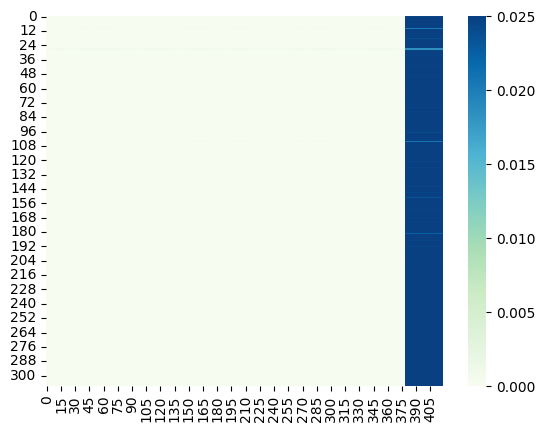

Saved best model

Epoch: 2/100


	Train Loss 1.4286	 Learning Rate 0.0009998
	Val Dist 479.5910%	 Val Loss 0.0000


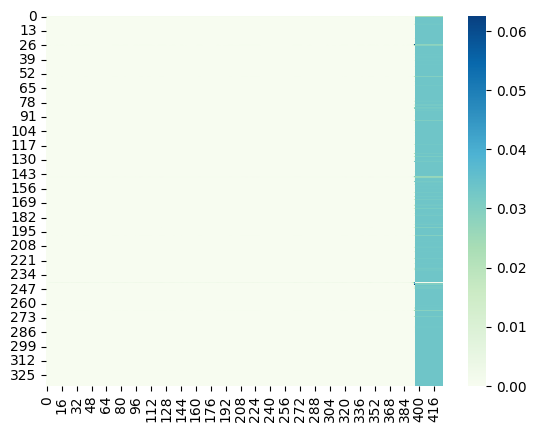

Saved best model

Epoch: 3/100


	Train Loss 1.3003	 Learning Rate 0.0009990
	Val Dist 473.2266%	 Val Loss 0.0000


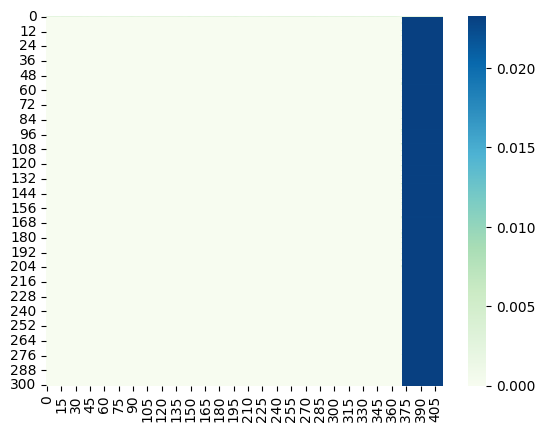

Saved best model

Epoch: 4/100


	Train Loss 1.2470	 Learning Rate 0.0009978
	Val Dist 493.2680%	 Val Loss 0.0000


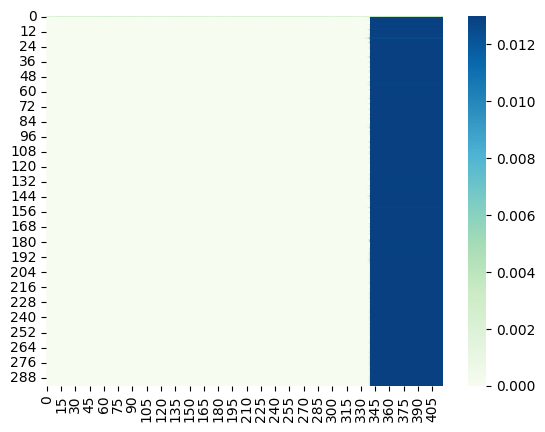


Epoch: 5/100


	Train Loss 1.2129	 Learning Rate 0.0009961
	Val Dist 487.5917%	 Val Loss 0.0000


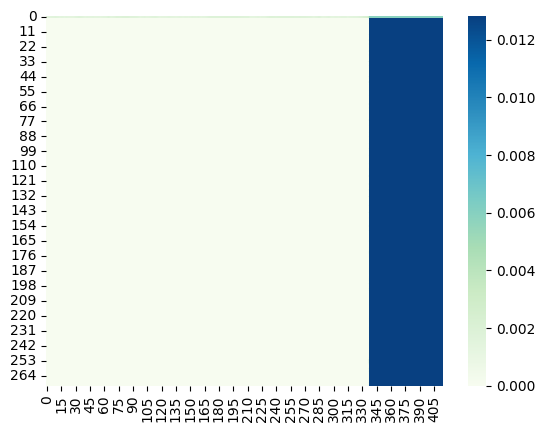


Epoch: 6/100


	Train Loss 1.1938	 Learning Rate 0.0009939
	Val Dist 469.7866%	 Val Loss 0.0000


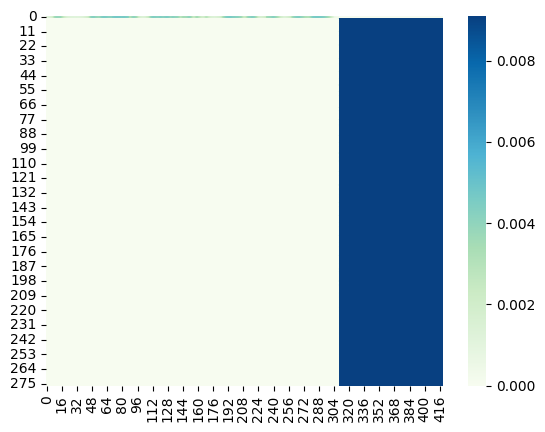

Saved best model

Epoch: 7/100


	Train Loss 1.1738	 Learning Rate 0.0009912
	Val Dist 473.3768%	 Val Loss 0.0000


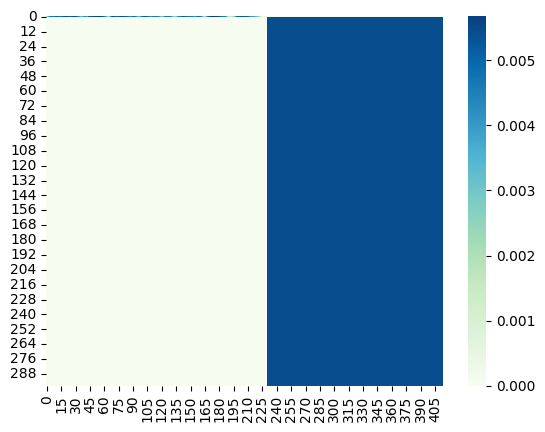


Epoch: 8/100


	Train Loss 1.1562	 Learning Rate 0.0009880
	Val Dist 481.9826%	 Val Loss 0.0000


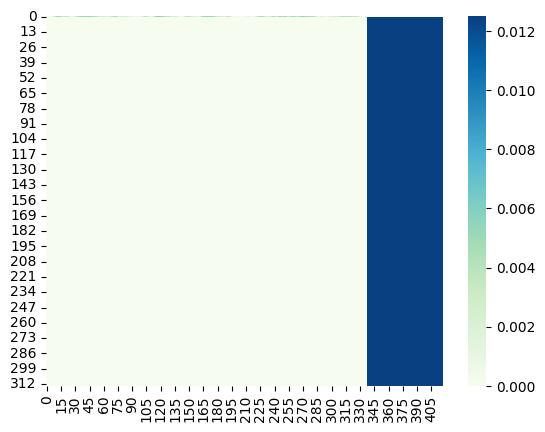


Epoch: 9/100


	Train Loss 1.1384	 Learning Rate 0.0009843
	Val Dist 477.1772%	 Val Loss 0.0000


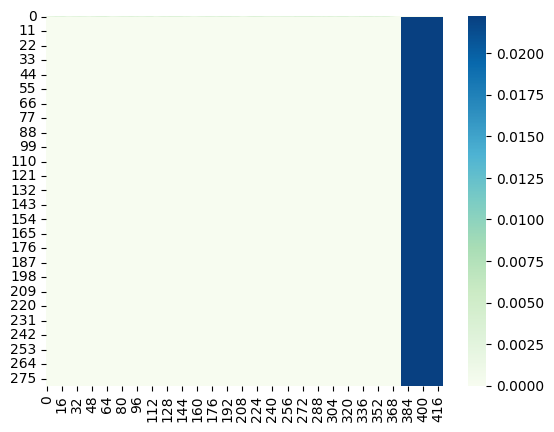


Epoch: 10/100


	Train Loss 1.1215	 Learning Rate 0.0009802
	Val Dist 476.6203%	 Val Loss 0.0000


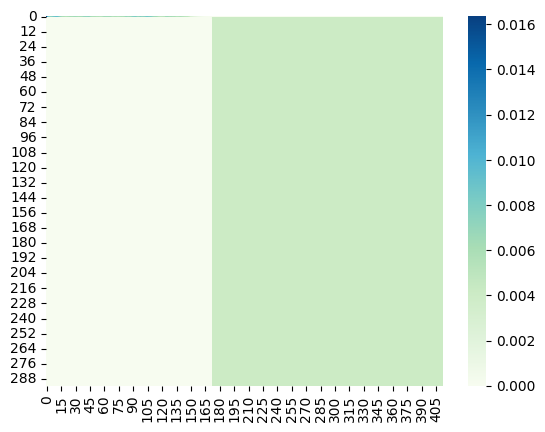


Epoch: 11/100


	Train Loss 1.1047	 Learning Rate 0.0009756
	Val Dist 472.1391%	 Val Loss 0.0000


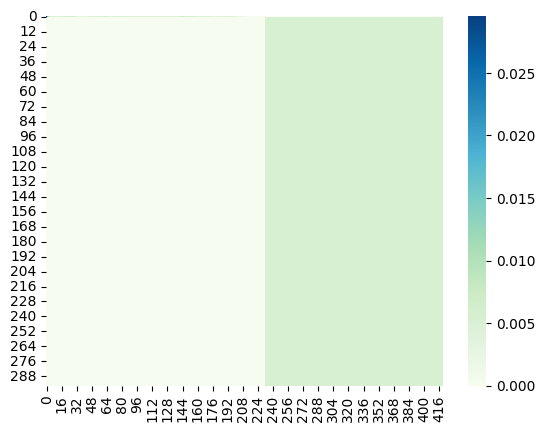


Epoch: 12/100


	Train Loss 1.0927	 Learning Rate 0.0009705
	Val Dist 482.3921%	 Val Loss 0.0000


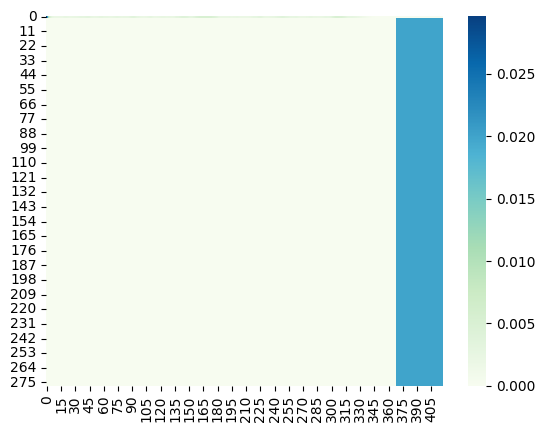


Epoch: 13/100


	Train Loss 1.0798	 Learning Rate 0.0009649
	Val Dist 476.8198%	 Val Loss 0.0000


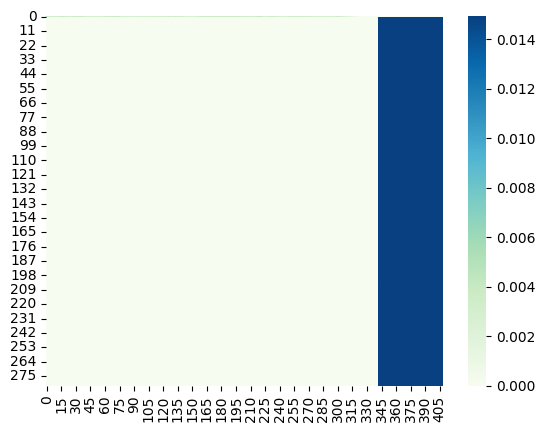


Epoch: 14/100


	Train Loss 1.0683	 Learning Rate 0.0009589
	Val Dist 474.1232%	 Val Loss 0.0000


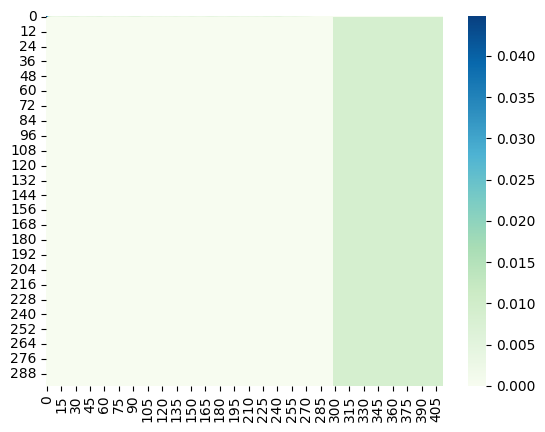


Epoch: 15/100


	Train Loss 1.0542	 Learning Rate 0.0009525
	Val Dist 203.8803%	 Val Loss 0.0000


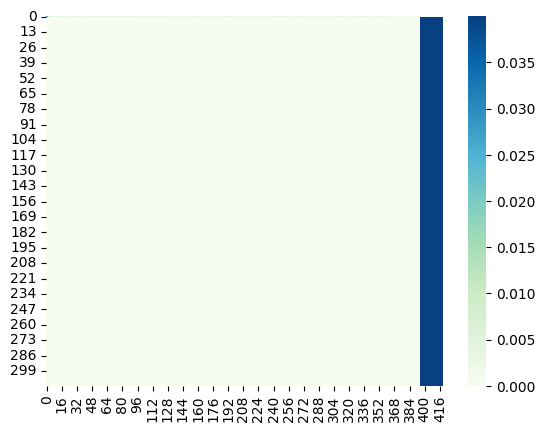

Saved best model

Epoch: 16/100


	Train Loss 1.0410	 Learning Rate 0.0009456
	Val Dist 238.4170%	 Val Loss 0.0000


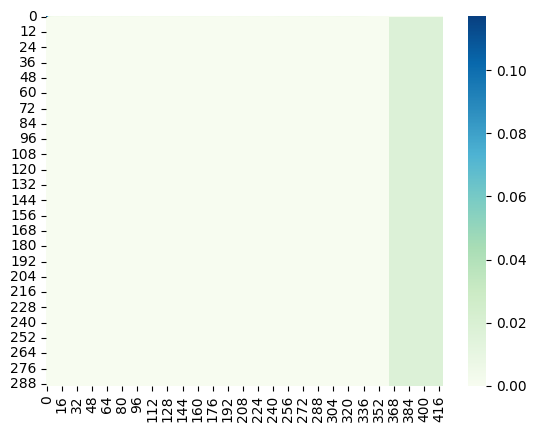


Epoch: 17/100


	Train Loss 1.0305	 Learning Rate 0.0009382
	Val Dist 487.4321%	 Val Loss 0.0000


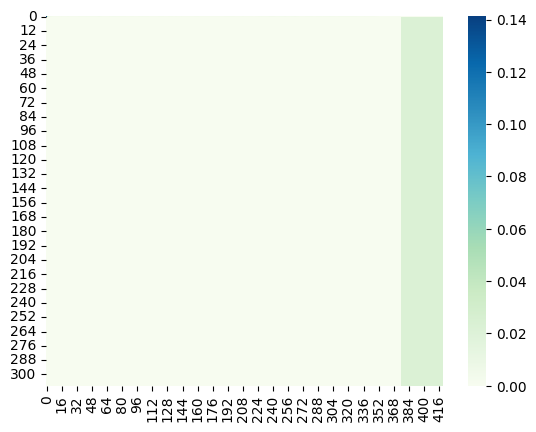


Epoch: 18/100


Train:  65%|██████▌   | 145/223 [02:48<01:30,  1.16s/it, loss=1.0161, lr=0.0009, perplexity=2.7626, tf_rate=1.00]

KeyboardInterrupt: 

In [97]:
best_lev_dist = float("inf")
tf_rate = 1.0

for epoch in range(0, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))
    curr_lr = float(optimizer.param_groups[0]['lr'])
    # Call train and validate, get attention weights from training
    teacher_forcing_ratio = 1
    train_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, teacher_forcing_ratio)
    valid_loss, valid_dist = validate(model, valid_loader)
    # Print your metrics
    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Dist {:.04f}%\t Val Loss {:.04f}".format(valid_dist, valid_loss))
    # Plot Attention for a single item in the batch
    plot_attention(attention_plot[0].cpu().detach().numpy())
    
    # Log metrics to Wandb
    wandb.log({
        'train_loss': train_loss,
        'valid_dist': valid_dist,
        'valid_loss': valid_loss,
        'lr'        : curr_lr
    })
    # Optional: Scheduler Step / Teacher Force Schedule Step
    scheduler.step()

    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        wandb.save(best_model_path)
        print("Saved best model")

run.finish()

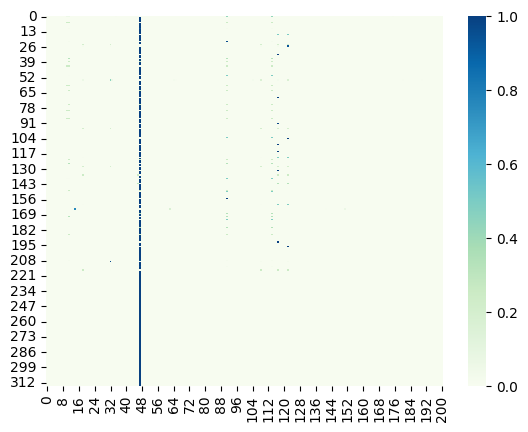

In [91]:
# attention_plot[0].cpu().detach().numpy()[0].max()
plot_attention(attention_plot.detach().cpu().numpy()[0])

# Testing

In [ ]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation
# TODO: Create a file with all predictions
# TODO: Submit to Kaggle